# Manual Labeled trained Models Notebook

Organizing and Labeling
- Splitting images: 80% train, 20% validation
- Flattening images into train/images, validation/images
- YOLO labels text files will be split and placed into their correspoding section for training, and validation sets
- Generating YAML file 

In [45]:
import torch
import os
import shutil
import random 
from glob import glob
import cv2
from tqdm import tqdm
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt

Specifying locations for data:

In [ ]:
# Directories:

doodle_images = r"C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data\images"
doodle_labels = r"C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data\labels"
dataset_directory = r"C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files"


train_image_directory = os.path.join(dataset_directory, "train", "images")
train_label_directory = os.path.join(dataset_directory, "train", "labels")
validation_image_directory = os.path.join(dataset_directory, "validation", "images")
validation_label_directory = os.path.join(dataset_directory, "validation", "labels")
test_image_directory = r"C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\images"
test_label_directory = r"C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\labels"


os.makedirs(train_image_directory, exist_ok=True)
os.makedirs(train_label_directory, exist_ok=True)
os.makedirs(validation_image_directory, exist_ok=True)
os.makedirs(validation_label_directory, exist_ok=True)




In [ ]:
# Gathering images
images = glob(os.path.join(doodle_images, "*.png"))
print(f"Found {len(images)} images in total.")

# Shuffling and splitting the dataset
random.shuffle(images)
split_index = int(0.8 * len(images))
train_images = images[:split_index]
validation_images = images[split_index:]

Found 1600 images in total.


In [48]:
# Function to move images and labels to their correspodning directories:
def move_images_and_labels(image_list, image_src, label_src, image_dest, label_dest):
    for image_path in image_list:
        filename = os.path.basename(image_path)
        base_name = os.path.splitext(filename)[0]
        label_filename = base_name + ".txt"
        label_path = os.path.join(label_src, label_filename)

        # Copy image
        shutil.copy(os.path.join(image_src, filename), os.path.join(image_dest, filename))

        # Copy label if it exists
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(label_dest, label_filename))
        else:
            print(f"Warning: Label file not found for image {filename}")

# Move training, validation, and test data to their corresponding directories
move_images_and_labels(train_images, doodle_images, doodle_labels, train_image_directory, train_label_directory)
move_images_and_labels(validation_images, doodle_images, doodle_labels, validation_image_directory, validation_label_directory)
# move_images_and_labels(test_images, doodle_images, doodle_labels, test_image_directory, test_label_directory)


In [34]:
# Function to check and normalize YOLO labels:

def check_and_normalize_yolo_labels(label_dir, image_width=640, image_height=640):
    print(f"Checking and normalizing: {label_dir}")
    
    txt_files = [f for f in os.listdir(label_dir) if f.endswith(".txt")]
    
    for file in tqdm(txt_files, desc=f"Processing {os.path.basename(label_dir)}", unit="file"):
        path = os.path.join(label_dir, file)
        with open(path, "r") as f:
            lines = f.readlines()

        fixed_lines = []
        needs_fix = False

        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                print(f"Invalid line in {file}: {line.strip()}")
                continue

            try:
                cls = int(parts[0])
                coords = list(map(float, parts[1:]))
            except ValueError:
                print(f"Non-numeric values in {file}: {line.strip()}")
                continue

            # Check if normalization is needed
            if any(val > 1.0 for val in coords):
                needs_fix = True
                x, y, w, h = coords
                x /= image_width
                y /= image_height
                w /= image_width
                h /= image_height
                coords = [x, y, w, h]

            fixed_line = f"{cls} {' '.join(f'{v:.6f}' for v in coords)}"
            fixed_lines.append(fixed_line)

        if needs_fix:
            with open(path, "w") as f:
                f.write("\n".join(fixed_lines) + "\n")

    print(f"Completed: {label_dir}\n")

In [ ]:
# check all label folders

check_and_normalize_yolo_labels(train_label_directory)
check_and_normalize_yolo_labels(validation_label_directory)
check_and_normalize_yolo_labels(test_label_directory)

In [38]:
# defining classes

classes = [
    "campfire",
    "cloud",
    "firetruck",
    "helicopter",
    "hospital",
    "mountain",
    "skull",
    "skyscraper",
    "tractor",
    "traffic light",
    "tree",
    "van"
]

In [39]:
# Creating YAML file:

yaml_path = os.path.join(dataset_directory, "data.yaml")
with open(yaml_path, "w") as f:
    f.write(
        f"train: {os.path.join(dataset_directory, 'train', 'images')}\n"
        f"val: {os.path.join(dataset_directory, 'validation', 'images')}\n\n"
        f"nc: {len(classes)}\n"
        f"names: {classes}\n"
    )

print(f"data.yaml created at: {yaml_path}")

data.yaml created at: C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data.yaml


### Training of Models: 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using: {device}')

model = YOLO('models/yolov8s.pt')

Using: cuda


First model trained on initial 300 manual labeled images: 

In [ ]:
num_workers = 2

model.train(
    data=yaml_path,
    epochs=25,              
    imgsz=640,              
    batch=16,
    lr0=0.01,              
    optimizer='SGD',        
    project="manual_yolo_runs",
    name="yolo8s_manual_model_1",
    exist_ok=True,
    device=device,
    workers=num_workers,   
    cache=True,             
    plots=False,            
    verbose=False          
)

New https://pypi.org/project/ultralytics/8.3.107 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=models/yolov8s.pt, data=C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=2, project=manual_yolo_runs, name=yolo8s_manual_model_1, exist_ok=True, pretrained=True, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_

train: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\train\labels... 295 images, 5 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 1695.68it/s]


train: New cache created: C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\train\labels.cache
WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.3GB RAM): 100%|██████████| 300/300 [00:00<00:00, 1536.74it/s]
val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels... 140 images, 30 backgrounds, 0 corrupt: 100%|██████████| 170/170 [00:00<00:00, 1751.28it/s]

val: New cache created: C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.2GB RAM): 100%|██████████| 170/170 [00:00<00:00, 2197.25it/s]


optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to manual_yolo_runs\yolo8s_manual_model_1
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.65G      1.186      4.694      1.288        100        640: 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

                   all        170        539    0.00793     0.0506    0.00895    0.00485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.11G     0.8944      2.521      1.096         51        640: 100%|██████████| 19/19 [00:02<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.20it/s]

                   all        170        539      0.306      0.244      0.171      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.13G     0.8221       1.69      1.042         58        640: 100%|██████████| 19/19 [00:02<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.02it/s]

                   all        170        539       0.46      0.525      0.429      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.13G     0.8299      1.425      1.018         44        640: 100%|██████████| 19/19 [00:02<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.30it/s]


                   all        170        539      0.545      0.676      0.629      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.15G     0.8523      1.173      1.028         71        640: 100%|██████████| 19/19 [00:02<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.34it/s]

                   all        170        539      0.614      0.708      0.657      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.15G     0.8434      1.152      1.024         77        640: 100%|██████████| 19/19 [00:02<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.73it/s]

                   all        170        539      0.605       0.67      0.654      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.18G     0.8089      1.052      1.001         67        640: 100%|██████████| 19/19 [00:02<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.80it/s]

                   all        170        539      0.693      0.767      0.712      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.18G      0.841     0.9267      1.019         85        640: 100%|██████████| 19/19 [00:02<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.37it/s]

                   all        170        539      0.704      0.726      0.716      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25       4.2G     0.8327     0.8379      1.033         71        640: 100%|██████████| 19/19 [00:02<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.62it/s]

                   all        170        539      0.694      0.789      0.711      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25       4.2G     0.8137     0.8283      1.019         72        640: 100%|██████████| 19/19 [00:02<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.48it/s]

                   all        170        539      0.702       0.81      0.741      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       4.2G     0.8297     0.7807      1.027        102        640: 100%|██████████| 19/19 [00:02<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]

                   all        170        539      0.733       0.79      0.726      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       4.2G     0.7797     0.7357       1.01         96        640: 100%|██████████| 19/19 [00:02<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.09it/s]

                   all        170        539      0.746      0.788      0.749      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       4.2G     0.7937     0.7278      1.023         98        640: 100%|██████████| 19/19 [00:02<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.08it/s]

                   all        170        539      0.669      0.835      0.759      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       4.2G     0.7776     0.6836      1.002         84        640: 100%|██████████| 19/19 [00:02<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.97it/s]

                   all        170        539      0.701      0.819      0.765      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       4.2G     0.7883     0.6692      1.018         66        640: 100%|██████████| 19/19 [00:02<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.85it/s]

                   all        170        539      0.624      0.835      0.739      0.604


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       4.2G     0.7464     0.6852      1.026         46        640: 100%|██████████| 19/19 [00:02<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

                   all        170        539       0.73      0.873      0.778      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25       4.2G     0.7371     0.6379      1.005         47        640: 100%|██████████| 19/19 [00:02<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

                   all        170        539      0.743      0.857      0.799      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25       4.2G     0.7238     0.5937      1.014         36        640: 100%|██████████| 19/19 [00:02<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.31it/s]

                   all        170        539      0.695      0.845      0.783       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25       4.2G     0.7202     0.6026      1.022         42        640: 100%|██████████| 19/19 [00:02<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.43it/s]

                   all        170        539      0.706        0.9      0.802      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25       4.2G     0.7169     0.5674      1.004         49        640: 100%|██████████| 19/19 [00:02<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.22it/s]

                   all        170        539       0.75      0.846      0.802      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25       4.2G     0.7103     0.5675     0.9961         40        640: 100%|██████████| 19/19 [00:01<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.05it/s]

                   all        170        539      0.754       0.85      0.823      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       4.2G     0.6858     0.5411     0.9771         47        640: 100%|██████████| 19/19 [00:02<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.81it/s]

                   all        170        539       0.79      0.863      0.833      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       4.2G     0.6894     0.5287      0.991         44        640: 100%|██████████| 19/19 [00:02<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        170        539      0.778      0.878      0.831      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       4.2G     0.6682     0.5063     0.9667         42        640: 100%|██████████| 19/19 [00:02<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.51it/s]

                   all        170        539      0.781      0.884      0.845      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25       4.2G     0.6835     0.4942     0.9743         45        640: 100%|██████████| 19/19 [00:02<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.95it/s]

                   all        170        539      0.803      0.893      0.851      0.703



25 epochs completed in 0.024 hours.
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1\weights\last.pt, 22.5MB
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1\weights\best.pt, 22.5MB

Validating manual_yolo_runs\yolo8s_manual_model_1\weights\best.pt...
Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.70it/s]

                   all        170        539      0.801      0.891      0.851      0.704
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.6ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000011251727710>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

### Visualing results of the first model trained on manually labeled data: 

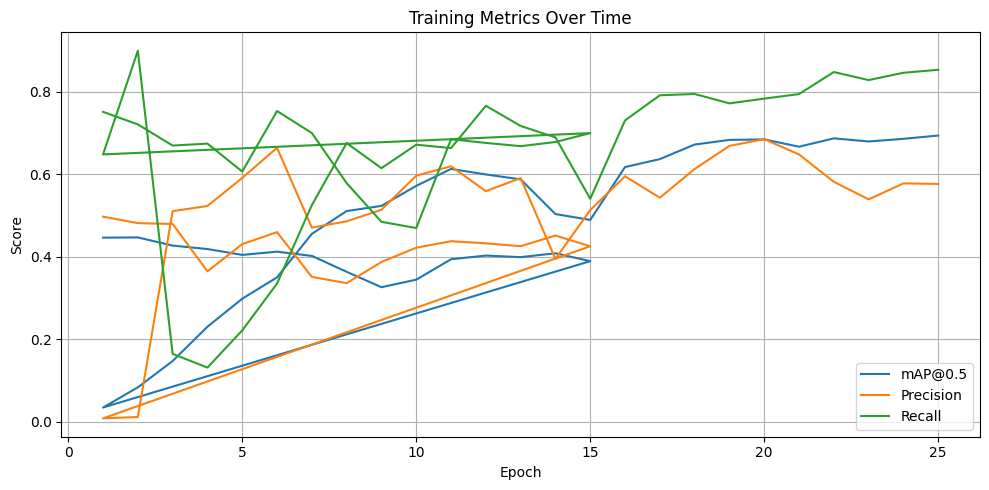

In [ ]:
results_path = "manual_yolo_runs/finetuned_model/results.csv"
df = pd.read_csv(results_path)

# Plot mAP over epochs
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Training Metrics Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


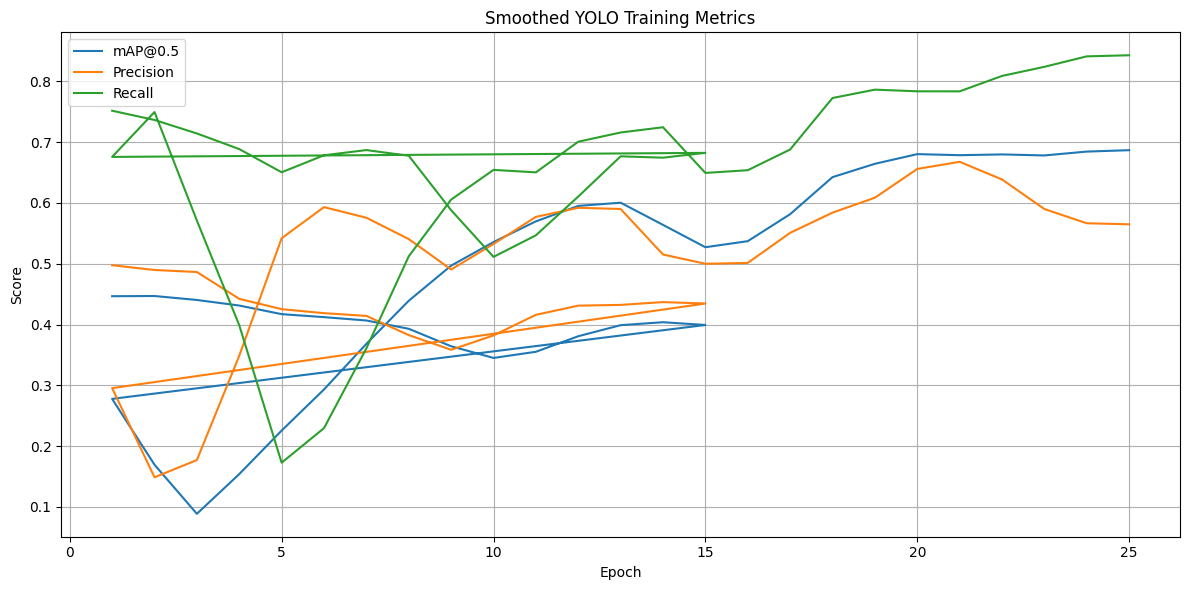

In [17]:
def smooth(y, box_pts=3):
    return pd.Series(y).rolling(box_pts, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], smooth(df['metrics/mAP50(B)']), label='mAP@0.5')
plt.plot(df['epoch'], smooth(df['metrics/precision(B)']), label='Precision')
plt.plot(df['epoch'], smooth(df['metrics/recall(B)']), label='Recall')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Smoothed YOLO Training Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


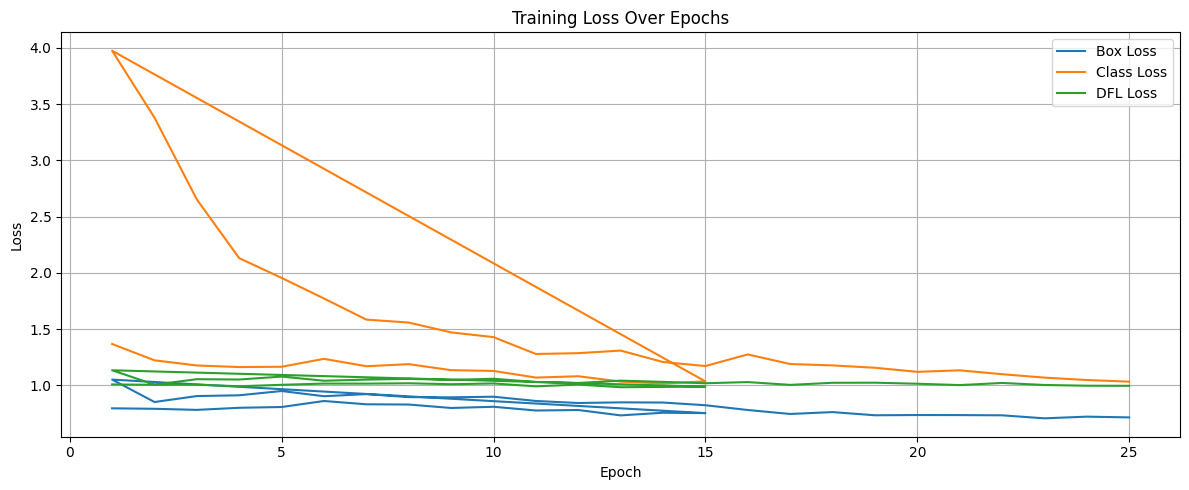

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
# If using YOLOv8 or DFL, include:
if 'train/dfl_loss' in df.columns:
    plt.plot(df['epoch'], df['train/dfl_loss'], label='DFL Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:


# Load the model
model = YOLO("manual_yolo_runs/finetuned_model/weights/best.pt")

# Run validation and capture metrics
metrics = model.val(data=yaml_path, save_json=True, plots=False)


Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 103 images, 40 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all        143        402      0.577      0.854      0.694      0.574
              campfire          4          4      0.226       0.25      0.241      0.205
                 cloud         20         25      0.653       0.96      0.692      0.592
             firetruck         13         15      0.429        0.8      0.581      0.448
            helicopter         94         96      0.657      0.979      0.682      0.565
              hospital         71         74      0.644      0.878      0.658      0.545
              mountain         20         22      0.674          1      0.909      0.745
                 skull         29         35      0.697      0.971      0.857      0.725
            skyscraper         24         28      0.605      0.679      0.722      0.534
               tractor         18         20      0.497        0.8      0.657      0.555
         traffic light         31         36      0.693          1      0.878      0.753
                  tre

Results saved to c:\Users\gabri\runs\detect\val


Reprinting results of first model: 

In [13]:
results_path = "manual_yolo_runs/finetuned_model/results.csv"
df = pd.read_csv(results_path)

print(df.columns.tolist())

['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


Loading original manual labeled test file containing 10 images and evaluating the model:

In [53]:
test_yaml_path = r'C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test_data.yaml'

In [ ]:
results = model.val(
    data= test_yaml_path,  
    split='test',
    conf=0.25,              
    save_json=True,         
    save_txt=True,         
    plots=True              
)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 799.60it/s]

val: New cache created: C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


                   all         10         39      0.742      0.875      0.835      0.739
              campfire          1          1          0          0          0          0
                 cloud          3          3      0.765          1      0.995      0.959
             firetruck          3          3          1          1      0.995      0.863
            helicopter         10         10      0.909          1      0.905      0.788
              hospital          5          5      0.833          1      0.895      0.803
              mountain          3          3          1      0.667      0.833       0.75
                 skull          1          1        0.5          1      0.995      0.895
            skyscraper          2          3      0.735          1       0.83        0.6
               tractor          2          2      0.667          1      0.663      0.597
         traffic light          1          1        0.5          1      0.995      0.895
                  tre

### Testing on Webcam:

In [ ]:
from IPython.display import display, clear_output

cap = cv2.VideoCapture(0)

for _ in range(30):  # Show 30 frames, or set to while True
    ret, frame = cap.read()
    if not ret:
        break

    # Convert BGR to RGB for display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    clear_output(wait=True)
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()

cap.release()
cv2.destroyAllWindows()

Printing image of live camera feed for illustration purposes: 

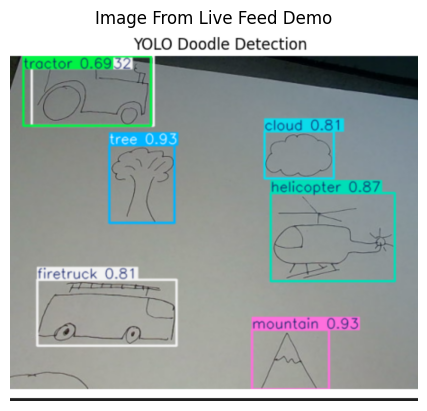

In [ ]:
live_feed_image_path = r"C:\MSAAI\AAI-590\Capstone-Local\live_feed_screenshot.png"


image = cv2.imread(live_feed_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Displaying the image
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Image From Live Feed Demo")
plt.show()


## Training from this point utilized the manual labeled dataset with 100 new images, having the 'campfire' class added to them. These 400 images were taken and then augmented to generate additional image data, totaling in 1600. 




### Model 1: 


In [ ]:
num_workers = 2

model.train(
    data=yaml_path,
    epochs=25,              
    imgsz=640,              
    batch=16,
    lr0=0.01,              
    optimizer='SGD',       
    project="manual_yolo_runs",
    name="yolo8s_manual_model_1600_1",
    exist_ok=True,
    device=device,
    workers=num_workers,    
    cache=True,             
    plots=False,           
    verbose=False          
)

New https://pypi.org/project/ultralytics/8.3.108 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=models/yolov8s.pt, data=C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=2, project=manual_yolo_runs, name=yolo8s_manual_model_1600_1, exist_ok=True, pretrained=True, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, 

train: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\train\labels.cache... 1280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1280/1280 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (1.5GB RAM): 100%|██████████| 1280/1280 [00:00<00:00, 2559.38it/s]
val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2347.55it/s]


optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to manual_yolo_runs\yolo8s_manual_model_1600_1
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.75G     0.3608     0.3085     0.8731        114        640: 100%|██████████| 80/80 [00:09<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]

                   all        320       1403      0.947      0.948      0.981      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.78G     0.3412     0.2868      0.866         92        640: 100%|██████████| 80/80 [00:08<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.62it/s]

                   all        320       1403      0.965      0.963      0.983      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25       3.8G     0.3707     0.3119     0.8774        129        640: 100%|██████████| 80/80 [00:08<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]

                   all        320       1403      0.966      0.956      0.984      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       3.8G     0.3795     0.3131     0.8797        121        640: 100%|██████████| 80/80 [00:08<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.26it/s]

                   all        320       1403      0.954      0.943       0.98      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25       3.8G     0.3987     0.3199     0.8887         97        640: 100%|██████████| 80/80 [00:08<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.70it/s]

                   all        320       1403      0.944      0.956      0.978      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       3.8G     0.4026     0.3256     0.8852        141        640: 100%|██████████| 80/80 [00:08<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.17it/s]

                   all        320       1403      0.926      0.936      0.972      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       3.8G     0.4009     0.3296     0.8832        124        640: 100%|██████████| 80/80 [00:08<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.39it/s]

                   all        320       1403      0.952      0.946      0.979      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25       3.8G     0.3996     0.3232     0.8902         88        640: 100%|██████████| 80/80 [00:08<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.08it/s]

                   all        320       1403      0.939      0.942      0.976      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25       3.8G      0.393     0.3199     0.8879        101        640: 100%|██████████| 80/80 [00:08<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]

                   all        320       1403      0.955      0.933       0.98      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25       3.8G     0.3979     0.3312      0.888         95        640: 100%|██████████| 80/80 [00:08<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.37it/s]

                   all        320       1403      0.939      0.947      0.975      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       3.8G      0.386     0.3251      0.884        109        640: 100%|██████████| 80/80 [00:08<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.37it/s]

                   all        320       1403       0.94       0.93      0.975       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       3.8G     0.3876      0.324     0.8859        130        640: 100%|██████████| 80/80 [00:08<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.57it/s]

                   all        320       1403      0.936      0.958      0.973      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       3.8G     0.3815     0.3115     0.8878         80        640: 100%|██████████| 80/80 [00:08<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.38it/s]

                   all        320       1403      0.932      0.958       0.98      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       3.8G     0.3785     0.3162     0.8878        141        640: 100%|██████████| 80/80 [00:08<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]

                   all        320       1403      0.934      0.944      0.975      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       3.8G     0.3735     0.3094     0.8811        113        640: 100%|██████████| 80/80 [00:08<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.22it/s]

                   all        320       1403      0.959      0.936      0.977      0.873


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       3.8G     0.4554     0.3102     0.9209         58        640: 100%|██████████| 80/80 [00:08<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]

                   all        320       1403      0.965       0.94      0.979      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25       3.8G     0.4553     0.3059     0.9247         69        640: 100%|██████████| 80/80 [00:08<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]

                   all        320       1403      0.955      0.958      0.983      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      3.82G     0.4316     0.2816     0.9043         62        640: 100%|██████████| 80/80 [00:08<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.70it/s]

                   all        320       1403      0.949       0.95      0.977      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      3.82G     0.4173     0.2705     0.8935         67        640: 100%|██████████| 80/80 [00:08<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]

                   all        320       1403      0.953      0.964      0.982      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      3.82G     0.4127     0.2652     0.8978         61        640: 100%|██████████| 80/80 [00:08<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]

                   all        320       1403      0.975      0.958      0.983      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      3.82G      0.405     0.2627     0.8926         72        640: 100%|██████████| 80/80 [00:08<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.75it/s]

                   all        320       1403      0.966      0.955      0.983      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      3.84G     0.3887     0.2448     0.8852         58        640: 100%|██████████| 80/80 [00:08<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]

                   all        320       1403      0.962      0.965      0.984      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      3.84G     0.3818     0.2407     0.8757         68        640: 100%|██████████| 80/80 [00:08<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.21it/s]

                   all        320       1403       0.97      0.966      0.988      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      3.84G     0.3783     0.2396     0.8776         71        640: 100%|██████████| 80/80 [00:08<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.04it/s]

                   all        320       1403       0.97      0.962      0.986      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      3.84G     0.3662     0.2313     0.8748         68        640: 100%|██████████| 80/80 [00:08<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]

                   all        320       1403      0.978      0.962      0.987      0.911



25 epochs completed in 0.074 hours.
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_1\weights\last.pt, 22.5MB
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_1\weights\best.pt, 22.5MB

Validating manual_yolo_runs\yolo8s_manual_model_1600_1\weights\best.pt...
Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]

                   all        320       1403      0.978      0.961      0.987       0.91
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.8ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000011251C25970>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [77]:
metrics_1 = model.val(data=yaml_path, save_json=True, plots=False)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2523.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.08it/s]

                   all        320       1403      0.978      0.962      0.987      0.911
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 0.6ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_1\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_1


In [78]:
results_1 = model.val(
    data= test_yaml_path,  
    split='test',
    conf=0.25,              
    save_json=True,         
    save_txt=True,         
    plots=True              
)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 30/30 [00:00<00:00, 2398.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


                   all         30        139      0.793      0.783      0.802      0.725
Speed: 1.3ms preprocess, 7.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_1\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_1


### Model 2:

In [ ]:
num_workers = 2

model.train(
    data=yaml_path,
    epochs=50,              
    imgsz=640,              
    batch=16,
    lr0=0.01,              
    optimizer='Adam',        
    project="manual_yolo_runs",
    name="yolo8s_manual_model_1600_2",
    exist_ok=True,
    device=device,
    workers=num_workers,    
    cache=True,             
    plots=False,            
    verbose=False           
)

New https://pypi.org/project/ultralytics/8.3.108 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=models/yolov8s.pt, data=C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=2, project=manual_yolo_runs, name=yolo8s_manual_model_1600_2, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\train\labels.cache... 1280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1280/1280 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (1.5GB RAM): 100%|██████████| 1280/1280 [00:00<00:00, 2637.61it/s]
val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2467.95it/s]


optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to manual_yolo_runs\yolo8s_manual_model_1600_2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.77G     0.6096      0.531     0.9666        123        640: 100%|██████████| 80/80 [00:09<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.00it/s]

                   all        320       1403      0.755      0.792      0.848      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.02G     0.6915     0.6366      1.005         98        640: 100%|██████████| 80/80 [00:08<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]

                   all        320       1403      0.667      0.719      0.728      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.02G     0.7632     0.7257      1.043        121        640: 100%|██████████| 80/80 [00:09<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.11it/s]

                   all        320       1403      0.659      0.747      0.754      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.02G     0.7671     0.7285      1.042        121        640: 100%|██████████| 80/80 [00:08<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]

                   all        320       1403      0.602      0.603      0.641      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.02G     0.7995     0.7696      1.064        106        640: 100%|██████████| 80/80 [00:08<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]

                   all        320       1403      0.707      0.723      0.776      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.06G      0.757     0.6974      1.033        134        640: 100%|██████████| 80/80 [00:08<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]

                   all        320       1403      0.719      0.725      0.799      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.09G      0.742     0.6659      1.027        113        640: 100%|██████████| 80/80 [00:09<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.58it/s]

                   all        320       1403      0.761      0.766      0.835      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.09G     0.7214     0.6415      1.021         92        640: 100%|██████████| 80/80 [00:09<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.17it/s]

                   all        320       1403      0.707      0.802       0.82      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.09G     0.7117     0.6439       1.02        103        640: 100%|██████████| 80/80 [00:08<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]

                   all        320       1403      0.729       0.63      0.722      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.09G     0.6961     0.6262      1.008         83        640: 100%|██████████| 80/80 [00:08<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.08it/s]

                   all        320       1403      0.762      0.785      0.837      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.09G     0.6626     0.5924     0.9913        117        640: 100%|██████████| 80/80 [00:08<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.02it/s]

                   all        320       1403      0.784      0.786      0.835      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.09G     0.6674     0.5754      0.996        128        640: 100%|██████████| 80/80 [00:08<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.31it/s]

                   all        320       1403      0.777      0.832      0.862      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.09G     0.6512     0.5644     0.9949         84        640: 100%|██████████| 80/80 [00:08<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.45it/s]

                   all        320       1403      0.774      0.806      0.849      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.09G     0.6416     0.5622     0.9867        161        640: 100%|██████████| 80/80 [00:08<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]

                   all        320       1403      0.799      0.818      0.861      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.09G     0.6403     0.5673     0.9885        117        640: 100%|██████████| 80/80 [00:08<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.94it/s]

                   all        320       1403      0.814      0.802      0.852      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.09G     0.6355     0.5392     0.9764        110        640: 100%|██████████| 80/80 [00:08<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.63it/s]

                   all        320       1403      0.817      0.822      0.876      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.09G     0.6019     0.5066     0.9691        104        640: 100%|██████████| 80/80 [00:08<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.17it/s]

                   all        320       1403      0.786      0.827      0.867      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.09G     0.5899     0.5054     0.9643         95        640: 100%|██████████| 80/80 [00:08<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.67it/s]

                   all        320       1403      0.845      0.825      0.899      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.09G     0.6035     0.5131     0.9718        117        640: 100%|██████████| 80/80 [00:08<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]

                   all        320       1403      0.827      0.848      0.895      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.09G     0.5863     0.5046     0.9698         85        640: 100%|██████████| 80/80 [00:08<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.54it/s]

                   all        320       1403      0.844      0.819      0.892      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.09G     0.5843      0.504     0.9647        107        640: 100%|██████████| 80/80 [00:08<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]

                   all        320       1403      0.818      0.814      0.876      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.09G     0.5828     0.4963     0.9595         93        640: 100%|██████████| 80/80 [00:08<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.76it/s]

                   all        320       1403      0.816      0.866      0.895      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.09G     0.5514     0.4698     0.9475         98        640: 100%|██████████| 80/80 [00:08<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.03it/s]

                   all        320       1403      0.815      0.849        0.9      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.09G     0.5669     0.4825      0.954        150        640: 100%|██████████| 80/80 [00:08<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.08it/s]

                   all        320       1403      0.855      0.853      0.909      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.09G     0.5365     0.4585     0.9426         99        640: 100%|██████████| 80/80 [00:08<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.44it/s]

                   all        320       1403      0.822      0.847      0.901      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.09G     0.5354     0.4589     0.9412        156        640: 100%|██████████| 80/80 [00:08<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]

                   all        320       1403      0.847       0.85        0.9       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.09G     0.5332     0.4416     0.9399        102        640: 100%|██████████| 80/80 [00:08<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.69it/s]

                   all        320       1403      0.863      0.885      0.914      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.09G     0.5207     0.4519     0.9449        106        640: 100%|██████████| 80/80 [00:08<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.15it/s]

                   all        320       1403      0.855      0.847      0.911       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.09G     0.5353     0.4554     0.9416        120        640: 100%|██████████| 80/80 [00:08<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.34it/s]

                   all        320       1403      0.808      0.859      0.892      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.09G     0.5111     0.4218     0.9296        119        640: 100%|██████████| 80/80 [00:08<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.30it/s]

                   all        320       1403      0.848      0.875      0.908      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.09G     0.5097     0.4297     0.9374        129        640: 100%|██████████| 80/80 [00:08<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.32it/s]

                   all        320       1403      0.848      0.885      0.924       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.09G     0.4964     0.4267     0.9304        155        640: 100%|██████████| 80/80 [00:08<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]

                   all        320       1403      0.876      0.857      0.926      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.09G     0.4901     0.4199     0.9236        122        640: 100%|██████████| 80/80 [00:08<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.10it/s]

                   all        320       1403      0.852       0.86       0.92      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.09G      0.495     0.4154     0.9293         98        640: 100%|██████████| 80/80 [00:08<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.66it/s]

                   all        320       1403      0.861      0.871       0.93      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.09G     0.4809     0.4066     0.9261         91        640: 100%|██████████| 80/80 [00:08<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


                   all        320       1403      0.867      0.904       0.93      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.09G     0.4641     0.3967     0.9237         97        640: 100%|██████████| 80/80 [00:08<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]

                   all        320       1403      0.901      0.862       0.93      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.09G     0.4574     0.3777     0.9139        158        640: 100%|██████████| 80/80 [00:08<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.34it/s]

                   all        320       1403      0.898      0.874      0.936      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.09G     0.4741     0.3927     0.9253        150        640: 100%|██████████| 80/80 [00:08<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.39it/s]

                   all        320       1403      0.889      0.889      0.939      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.09G     0.4577     0.3884     0.9214        147        640: 100%|██████████| 80/80 [00:08<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]

                   all        320       1403        0.9      0.911       0.95      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.09G     0.4521     0.3729     0.9125        115        640: 100%|██████████| 80/80 [00:08<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]

                   all        320       1403      0.891      0.895      0.944       0.81


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.09G     0.6162     0.4466      1.012         65        640: 100%|██████████| 80/80 [00:09<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]

                   all        320       1403      0.881      0.897      0.943       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.09G      0.613     0.4423     0.9998         64        640: 100%|██████████| 80/80 [00:08<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.42it/s]

                   all        320       1403      0.889        0.9      0.945      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.09G     0.5945     0.4141     0.9864         62        640: 100%|██████████| 80/80 [00:08<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]

                   all        320       1403      0.918       0.92      0.962      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.09G      0.577     0.4014     0.9791         58        640: 100%|██████████| 80/80 [00:09<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.00it/s]

                   all        320       1403      0.929      0.927      0.969      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.09G     0.5549     0.3663     0.9671         81        640: 100%|██████████| 80/80 [00:09<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.05it/s]

                   all        320       1403      0.923      0.922      0.962      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.09G     0.5497     0.3616     0.9665         58        640: 100%|██████████| 80/80 [00:09<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]

                   all        320       1403      0.925      0.936       0.97      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.09G     0.5306     0.3451      0.951         69        640: 100%|██████████| 80/80 [00:09<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.47it/s]

                   all        320       1403      0.932      0.925      0.968      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.12G      0.519     0.3256     0.9474         61        640: 100%|██████████| 80/80 [00:08<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]

                   all        320       1403      0.941      0.936      0.972      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.15G     0.5008     0.3139     0.9389         61        640: 100%|██████████| 80/80 [00:09<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.00it/s]

                   all        320       1403      0.947      0.963      0.981      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.19G     0.4849     0.2965     0.9299         64        640: 100%|██████████| 80/80 [00:09<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.88it/s]

                   all        320       1403      0.956      0.956       0.98      0.877



50 epochs completed in 0.149 hours.
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_2\weights\last.pt, 22.5MB
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_2\weights\best.pt, 22.5MB

Validating manual_yolo_runs\yolo8s_manual_model_1600_2\weights\best.pt...
Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]

                   all        320       1403      0.956      0.956       0.98      0.878
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.7ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001133FB86300>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [81]:
metrics_2 = model.val(data=yaml_path, save_json=True, plots=False)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2573.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.67it/s]

                   all        320       1403      0.956      0.956       0.98      0.877
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_2\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_2


In [82]:
results_2 = model.val(
    data= test_yaml_path,  
    split='test',
    conf=0.25,              
    save_json=True,         
    save_txt=True,         
    plots=True              
)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 30/30 [00:00<00:00, 2220.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


                   all         30        139      0.808      0.879      0.846      0.761
Speed: 2.0ms preprocess, 10.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_2\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_2


### Model 3:

In [ ]:
num_workers = 4

model.train(
    data=yaml_path,
    epochs=50,              
    imgsz=640,              
    batch=32,
    lr0=0.01,               
    optimizer='Adam',        
    project="manual_yolo_runs",
    name="yolo8s_manual_model_1600_3",
    exist_ok=True,
    device=device,
    workers=num_workers,    
    cache=True,            
    plots=False,            
    verbose=False,          
    warmup_epochs=3,
    momentum=0.937,   
    weight_decay=0.0005
)

New https://pypi.org/project/ultralytics/8.3.108 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=models/yolov8s.pt, data=C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=4, project=manual_yolo_runs, name=yolo8s_manual_model_1600_3, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\train\labels.cache... 1280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1280/1280 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (1.5GB RAM): 100%|██████████| 1280/1280 [00:00<00:00, 2604.71it/s]
val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2133.64it/s]


optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to manual_yolo_runs\yolo8s_manual_model_1600_3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.23G      0.847     0.9053      1.086        239        640: 100%|██████████| 40/40 [00:09<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

                   all        320       1403      0.376      0.238      0.203      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.09G     0.7813       0.78       1.04        225        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        320       1403      0.565      0.527      0.549      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.09G     0.8045     0.7669      1.052        188        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        320       1403      0.494      0.447       0.43       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.09G     0.7937     0.7478      1.047        251        640: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

                   all        320       1403      0.537       0.39      0.373      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.09G      0.784     0.7231      1.045        188        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

                   all        320       1403      0.745       0.69      0.742      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.09G     0.7652     0.7094       1.04        208        640: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        320       1403      0.632      0.671      0.673      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.09G     0.7491     0.6821      1.028        278        640: 100%|██████████| 40/40 [00:08<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        320       1403      0.727      0.709      0.752      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.09G     0.7282     0.6501      1.013        268        640: 100%|██████████| 40/40 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        320       1403      0.652      0.625      0.692      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.09G     0.7522     0.6685      1.035        190        640: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all        320       1403      0.716      0.737      0.802      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.09G     0.7102     0.6064      1.013        185        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        320       1403       0.75      0.772      0.819      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.09G     0.7015     0.6027     0.9999        267        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        320       1403      0.785      0.737      0.823      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.09G     0.6816     0.5934     0.9952        212        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        320       1403      0.794      0.776      0.836      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.09G     0.6695     0.5666     0.9897        209        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        320       1403       0.76      0.807      0.844      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.09G     0.6586     0.5562     0.9857        254        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        320       1403      0.819       0.84      0.888      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.09G     0.6683     0.5718     0.9933        190        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        320       1403      0.826      0.836       0.88      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.09G     0.6603     0.5467     0.9872        201        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all        320       1403       0.82       0.83      0.883      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.09G     0.6658     0.5494     0.9969        233        640: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

                   all        320       1403      0.761      0.726      0.808      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.09G     0.6374     0.5291     0.9781        204        640: 100%|██████████| 40/40 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]

                   all        320       1403      0.809      0.864      0.892      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.09G      0.608     0.5171     0.9683        207        640: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

                   all        320       1403      0.812       0.83      0.881      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.09G     0.6155     0.5148     0.9687        204        640: 100%|██████████| 40/40 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        320       1403      0.807      0.807      0.866      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.09G     0.6162     0.5198     0.9687        300        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        320       1403      0.838       0.81       0.88      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.09G     0.5998     0.5053     0.9654        277        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        320       1403      0.798      0.828      0.887      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.09G     0.6049     0.5103     0.9651        205        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        320       1403      0.828      0.846      0.903      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.09G     0.5844     0.4889     0.9612        240        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        320       1403      0.849      0.851       0.91      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.09G     0.5932     0.4898     0.9638        232        640: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        320       1403      0.786      0.548      0.629      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.09G     0.5952     0.4854     0.9656        253        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        320       1403      0.864      0.863      0.915      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.09G     0.5614     0.4699     0.9496        210        640: 100%|██████████| 40/40 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

                   all        320       1403      0.811      0.871      0.905      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.09G     0.5631     0.4657     0.9495        233        640: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        320       1403      0.862      0.865      0.915      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.09G     0.5553     0.4618     0.9456        232        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        320       1403      0.859      0.875      0.919      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.09G     0.5423     0.4567     0.9452        209        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all        320       1403      0.848      0.862      0.913      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.12G     0.5463     0.4472     0.9461        236        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

                   all        320       1403      0.833      0.833      0.893      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.13G     0.5215     0.4296     0.9305        258        640: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        320       1403      0.864      0.877      0.927      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.13G      0.516     0.4188     0.9314        215        640: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        320       1403      0.854      0.887      0.928      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.13G      0.521      0.424     0.9296        192        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

                   all        320       1403      0.879      0.866      0.924      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.13G     0.5102     0.4184     0.9301        245        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]

                   all        320       1403      0.874      0.879      0.931      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.13G     0.5113     0.4207     0.9337        223        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        320       1403      0.903      0.867      0.925      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.13G     0.5007     0.4111     0.9305        193        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

                   all        320       1403      0.881      0.879      0.928      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.13G     0.4956     0.3967     0.9257        214        640: 100%|██████████| 40/40 [00:08<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

                   all        320       1403      0.889      0.908      0.943      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.13G     0.4791     0.3881     0.9231        203        640: 100%|██████████| 40/40 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        320       1403      0.916      0.875      0.941      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.13G     0.4758     0.3834     0.9208        261        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

                   all        320       1403      0.903       0.88      0.944      0.815


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.13G     0.5739     0.4174     0.9884        131        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

                   all        320       1403      0.848      0.855      0.924      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.13G     0.5641     0.3977     0.9794        137        640: 100%|██████████| 40/40 [00:08<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

                   all        320       1403      0.875      0.873      0.926      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.13G     0.5537     0.3833     0.9719        130        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        320       1403      0.895      0.896      0.949      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.13G     0.5454     0.3721     0.9656        132        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        320       1403      0.911      0.922      0.956      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.13G      0.521     0.3373     0.9508        143        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        320       1403       0.93      0.917      0.963      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.13G     0.4983     0.3245      0.941        127        640: 100%|██████████| 40/40 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all        320       1403      0.932      0.937      0.971      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.13G     0.4897      0.307     0.9421        138        640: 100%|██████████| 40/40 [00:08<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

                   all        320       1403      0.951      0.942      0.976      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.13G     0.4756     0.2987     0.9326        127        640: 100%|██████████| 40/40 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

                   all        320       1403      0.947      0.951      0.977      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.13G      0.469     0.2943      0.925        122        640: 100%|██████████| 40/40 [00:08<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        320       1403      0.962      0.949       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.13G     0.4536     0.2732     0.9174        109        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        320       1403      0.962      0.951      0.981       0.89



50 epochs completed in 0.144 hours.
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_3\weights\last.pt, 22.5MB
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_3\weights\best.pt, 22.5MB

Validating manual_yolo_runs\yolo8s_manual_model_1600_3\weights\best.pt...
Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.30it/s]

                   all        320       1403      0.962      0.951      0.981       0.89
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 0.5ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000115413D7080>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [84]:
metrics_3 = model.val(data=yaml_path, save_json=True, plots=False)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2497.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.38it/s]

                   all        320       1403      0.962      0.951      0.981      0.891
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_3\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_3


In [85]:
results_3 = model.val(
    data= test_yaml_path,  
    split='test',
    conf=0.25,              
    save_json=True,         
    save_txt=True,         
    plots=True              
)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 30/30 [00:00<00:00, 2724.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


                   all         30        139      0.842       0.79      0.831      0.755
Speed: 1.3ms preprocess, 10.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_3\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_3


### Model 4: 

In [ ]:
num_workers = 4

model.train(
    data=yaml_path,
    epochs=60,              
    imgsz=640,             
    batch=32,
    lr0=0.01,               
    optimizer='Adam',        
    project="manual_yolo_runs",
    name="yolo8s_manual_model_1600_4",
    exist_ok=True,
    device=device,
    workers=num_workers,   
    cache=True,             
    plots=False,            
    verbose=False,           
    warmup_epochs=3,
    momentum=0.937,   
    weight_decay=0.0005
)

New https://pypi.org/project/ultralytics/8.3.108 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=models/yolov8s.pt, data=C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data.yaml, epochs=60, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=4, project=manual_yolo_runs, name=yolo8s_manual_model_1600_4, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\train\labels.cache... 1280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1280/1280 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (1.5GB RAM): 100%|██████████| 1280/1280 [00:00<00:00, 2555.03it/s]
val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2384.12it/s]


optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to manual_yolo_runs\yolo8s_manual_model_1600_4
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60       6.9G     0.8029     0.8264      1.061        242        640: 100%|██████████| 40/40 [00:09<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all        320       1403      0.654      0.586      0.648      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      7.33G     0.7349     0.7084      1.022        231        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all        320       1403      0.596      0.638      0.648      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      7.33G      0.748     0.7167      1.025        194        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        320       1403      0.549      0.514      0.527      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      7.33G     0.7658     0.7165       1.03        235        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

                   all        320       1403      0.588      0.493      0.475      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      7.37G     0.7482     0.6884       1.03        204        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        320       1403      0.645       0.66      0.674      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      7.38G     0.7463     0.6772      1.027        212        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        320       1403      0.687      0.635      0.673      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      7.38G     0.7264     0.6656       1.02        279        640: 100%|██████████| 40/40 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        320       1403    0.00377     0.0343    0.00473    0.00208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      7.38G     0.6951     0.6243      1.003        240        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]

                   all        320       1403    0.00227    0.00206     0.0016   0.000587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      7.38G     0.7071     0.6242      1.014        188        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        320       1403      0.669      0.625      0.667       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      7.38G     0.6795     0.5862          1        198        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        320       1403      0.474      0.271      0.282      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      7.38G     0.6599     0.5774     0.9857        266        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        320       1403      0.817      0.796      0.855      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      7.38G     0.6631     0.5826     0.9941        226        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        320       1403      0.817      0.809      0.856      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      7.38G     0.6382     0.5445     0.9755        196        640: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        320       1403      0.842      0.793      0.878      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      7.38G     0.6533     0.5503      0.988        245        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        320       1403      0.837      0.784      0.869      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      7.38G     0.6448     0.5394     0.9828        202        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        320       1403      0.851       0.81      0.877      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      7.38G     0.6245      0.517     0.9765        203        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all        320       1403      0.686      0.397       0.44      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      7.38G     0.6182     0.5188     0.9795        256        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

                   all        320       1403      0.808      0.815       0.87      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      7.38G     0.6085      0.517     0.9719        196        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        320       1403      0.827      0.785      0.882      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      7.38G      0.597     0.4999     0.9612        207        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

                   all        320       1403       0.82       0.82      0.884      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      7.38G     0.5865     0.4975     0.9568        207        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        320       1403      0.809      0.825      0.874      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      7.38G     0.5887     0.4879     0.9594        289        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        320       1403       0.86      0.848      0.906       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      7.38G     0.5737     0.4818     0.9545        271        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        320       1403      0.863      0.865      0.907      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      7.38G      0.597     0.5038     0.9621        211        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        320       1403       0.86      0.887      0.916       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      7.38G     0.5882     0.4895     0.9622        232        640: 100%|██████████| 40/40 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        320       1403      0.785      0.515      0.598      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      7.38G     0.5713     0.4852     0.9581        209        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]

                   all        320       1403      0.887      0.841      0.917      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      7.38G     0.5739     0.4784     0.9585        266        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]

                   all        320       1403      0.856      0.787      0.884      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      7.38G     0.5415     0.4611      0.943        213        640: 100%|██████████| 40/40 [00:09<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

                   all        320       1403      0.842      0.835      0.894      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      7.38G     0.5455     0.4621     0.9419        240        640: 100%|██████████| 40/40 [00:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all        320       1403      0.824      0.839      0.875      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      7.38G     0.5394     0.4724     0.9388        223        640: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        320       1403      0.853      0.885       0.92      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      7.38G     0.5363     0.4622     0.9438        205        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        320       1403      0.777      0.803       0.88      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60       7.4G     0.5348     0.4424     0.9402        238        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        320       1403      0.894      0.862      0.926      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      7.44G     0.5228      0.435     0.9348        257        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        320       1403      0.853      0.886      0.932      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      7.47G     0.5193     0.4299     0.9334        207        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        320       1403      0.895      0.888      0.936      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      7.48G     0.5179     0.4299     0.9318        197        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        320       1403      0.575     0.0969      0.122     0.0892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      7.48G     0.5035     0.4176     0.9304        245        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        320       1403      0.726      0.548      0.608      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      7.48G     0.5203     0.4291     0.9371        222        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all        320       1403      0.898       0.89      0.937      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      7.48G     0.5012     0.4163     0.9287        201        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        320       1403        0.9       0.88      0.933      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      7.48G     0.5032     0.4089     0.9264        226        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        320       1403      0.887      0.889       0.93      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      7.48G     0.4882     0.4016     0.9259        226        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

                   all        320       1403      0.858      0.844      0.913      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      7.48G     0.4882     0.3992     0.9245        258        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]

                   all        320       1403      0.858      0.912      0.938       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      7.48G     0.4813     0.3972     0.9205        234        640: 100%|██████████| 40/40 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        320       1403      0.904       0.86      0.937      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      7.48G     0.4841     0.4011     0.9255        214        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        320       1403      0.909      0.882      0.944      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      7.48G     0.4697     0.3819     0.9145        225        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        320       1403      0.919      0.907      0.951      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      7.48G     0.4767     0.3881     0.9183        232        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        320       1403      0.869      0.922       0.94      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      7.48G     0.4688     0.3778     0.9079        185        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        320       1403      0.916      0.922      0.951      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      7.48G      0.467       0.38     0.9221        215        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

                   all        320       1403      0.899      0.922       0.95      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      7.48G     0.4522     0.3659     0.9138        209        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        320       1403      0.903      0.916      0.948      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      7.48G     0.4626      0.374     0.9139        210        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]

                   all        320       1403      0.904      0.912      0.953      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      7.48G     0.4522     0.3665     0.9127        213        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        320       1403      0.919      0.916       0.96      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      7.48G     0.4497     0.3558     0.9119        278        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        320       1403      0.893      0.906      0.947      0.823


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      7.48G     0.5431     0.3776     0.9702        136        640: 100%|██████████| 40/40 [00:08<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all        320       1403      0.916      0.935      0.964      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      7.48G     0.5273     0.3568     0.9543        121        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        320       1403      0.905       0.92      0.952      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      7.48G     0.5077     0.3264     0.9454        130        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        320       1403      0.929      0.933      0.965      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      7.48G     0.4944     0.3239     0.9356        137        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all        320       1403      0.938      0.916      0.968      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      7.48G      0.481      0.316     0.9375        129        640: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

                   all        320       1403      0.918      0.956      0.977      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      7.48G     0.4625     0.2918     0.9196        133        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

                   all        320       1403       0.94      0.936      0.971      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      7.48G     0.4512      0.287     0.9193        124        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

                   all        320       1403      0.954      0.958      0.981      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      7.48G      0.434     0.2717      0.904        134        640: 100%|██████████| 40/40 [00:08<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        320       1403      0.948      0.952       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      7.48G     0.4338     0.2726     0.9093        139        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

                   all        320       1403      0.955      0.961      0.982       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      7.48G      0.431     0.2716     0.9081        118        640: 100%|██████████| 40/40 [00:08<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]

                   all        320       1403      0.962      0.956      0.983      0.894



60 epochs completed in 0.174 hours.
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_4\weights\last.pt, 22.5MB
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_4\weights\best.pt, 22.5MB

Validating manual_yolo_runs\yolo8s_manual_model_1600_4\weights\best.pt...
Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.39it/s]

                   all        320       1403      0.963      0.955      0.983      0.894
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.7ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001129A9125A0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [87]:
metrics_4 = model.val(data=yaml_path, save_json=True, plots=False)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2560.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.14it/s]

                   all        320       1403      0.963      0.956      0.983      0.896
Speed: 0.3ms preprocess, 3.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_4\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_4


In [88]:
results_4 = model.val(
    data= test_yaml_path,  
    split='test',
    conf=0.25,              
    save_json=True,         
    save_txt=True,         
    plots=True              
)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 30/30 [00:00<00:00, 2433.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


                   all         30        139      0.775      0.829      0.807      0.735
Speed: 1.3ms preprocess, 10.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_4\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_4


### Model 5: 

In [ ]:
num_workers = 4

model.train(
    data=yaml_path,
    epochs=80,              
    imgsz=640,              
    batch=32,
    lr0=0.01,               
    optimizer='Adam',       
    project="manual_yolo_runs",
    name="yolo8s_manual_model_1600_5",
    exist_ok=True,
    device=device,
    workers=num_workers,   
    cache=True,             
    plots=False,            
    verbose=False,          
    warmup_epochs=3,
    momentum=0.937,   
    weight_decay=0.0005
)

New https://pypi.org/project/ultralytics/8.3.108 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=models/yolov8s.pt, data=C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data.yaml, epochs=80, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=4, project=manual_yolo_runs, name=yolo8s_manual_model_1600_5, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\train\labels.cache... 1280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1280/1280 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (1.5GB RAM): 100%|██████████| 1280/1280 [00:00<00:00, 2629.91it/s]
val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2133.29it/s]


optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to manual_yolo_runs\yolo8s_manual_model_1600_5
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      6.92G      0.764     0.7862      1.041        250        640: 100%|██████████| 40/40 [00:09<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        320       1403      0.568      0.576      0.547      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      7.38G     0.7156     0.6836      1.015        233        640: 100%|██████████| 40/40 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

                   all        320       1403      0.539      0.486       0.49      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      7.38G     0.7353     0.6856      1.023        190        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

                   all        320       1403      0.662      0.505      0.533      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      7.38G     0.7487     0.7058      1.029        264        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        320       1403      0.626      0.496      0.552      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      7.38G      0.732     0.6489       1.02        194        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        320       1403      0.525      0.577      0.602      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      7.38G     0.7036     0.6303       1.01        212        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all        320       1403      0.693      0.636      0.685      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      7.38G     0.6799     0.6111     0.9962        268        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        320       1403       0.72      0.768      0.796       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      7.38G     0.6721      0.602     0.9938        272        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]

                   all        320       1403   0.000104    0.00496   5.54e-05   1.63e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      7.38G     0.6907      0.616      1.006        194        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

                   all        320       1403      0.751      0.764      0.825      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      7.38G     0.6591     0.5882     0.9917        175        640: 100%|██████████| 40/40 [00:09<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

                   all        320       1403      0.651      0.663      0.696      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      7.38G     0.6395     0.5555     0.9785        256        640: 100%|██████████| 40/40 [00:08<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all        320       1403      0.809      0.768      0.845      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      7.38G     0.6343     0.5596     0.9825        222        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

                   all        320       1403      0.777      0.785      0.852      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      7.38G     0.6368     0.5326     0.9765        222        640: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        320       1403      0.816       0.79      0.858      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      7.38G     0.6172     0.5351     0.9734        252        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        320       1403       0.82      0.791      0.857      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      7.38G       0.63      0.538     0.9769        203        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

                   all        320       1403      0.816      0.818      0.884      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      7.38G     0.6183     0.5204     0.9702        195        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        320       1403      0.822      0.846      0.886      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      7.38G     0.6114     0.5205     0.9769        236        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

                   all        320       1403      0.831      0.842      0.907      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80       7.4G     0.5886     0.5025     0.9625        200        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

                   all        320       1403      0.831      0.828      0.884      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      7.44G     0.5941     0.4982     0.9594        209        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        320       1403      0.628     0.0967      0.142       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      7.47G     0.5781     0.4961     0.9605        197        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all        320       1403      0.876      0.814      0.902      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      7.48G     0.5929     0.5169     0.9652        289        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        320       1403      0.811      0.833      0.887      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      7.48G     0.5794     0.5001      0.955        248        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]

                   all        320       1403      0.814      0.842      0.893      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      7.48G     0.5782     0.4956     0.9572        209        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

                   all        320       1403      0.855      0.881      0.922      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      7.48G     0.5772     0.4874     0.9563        228        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

                   all        320       1403      0.858      0.803      0.894      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      7.48G     0.5729     0.4903     0.9623        232        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all        320       1403      0.848      0.808      0.873      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      7.48G     0.5838     0.4795     0.9613        237        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all        320       1403      0.876       0.85      0.919       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      7.48G     0.5494     0.4737     0.9481        216        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        320       1403      0.809      0.863      0.902      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      7.48G     0.5666     0.4874     0.9524        237        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        320       1403      0.849      0.814      0.892      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      7.48G     0.5528     0.4588     0.9431        224        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        320       1403      0.844      0.867      0.912      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      7.48G     0.5462     0.4544     0.9449        219        640: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

                   all        320       1403     0.0233     0.0177     0.0156     0.0109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      7.48G     0.5528     0.4585     0.9432        267        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        320       1403      0.713      0.356      0.397      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      7.48G     0.5223     0.4299     0.9355        247        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        320       1403      0.901      0.881      0.936        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      7.48G     0.5156     0.4194     0.9317        209        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        320       1403      0.821      0.841      0.894      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      7.48G     0.5186     0.4386     0.9318        194        640: 100%|██████████| 40/40 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        320       1403      0.848      0.915      0.928      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      7.48G     0.5149     0.4337     0.9355        232        640: 100%|██████████| 40/40 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]

                   all        320       1403    0.00191     0.0105    0.00292   0.000625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      7.48G     0.5312     0.4397     0.9385        230        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        320       1403      0.832      0.832      0.911       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      7.48G     0.5322     0.4438     0.9442        203        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        320       1403      0.878       0.86      0.917      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      7.48G     0.5192     0.4367      0.936        224        640: 100%|██████████| 40/40 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        320       1403      0.868      0.888      0.934      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      7.48G      0.506     0.4269     0.9352        209        640: 100%|██████████| 40/40 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        320       1403      0.853      0.821      0.907      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      7.48G     0.4998     0.4184     0.9299        257        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        320       1403      0.844      0.884      0.931      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      7.48G     0.4972     0.4097     0.9267        241        640: 100%|██████████| 40/40 [00:08<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

                   all        320       1403      0.879      0.838      0.919      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      7.48G     0.5055     0.4229     0.9326        229        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        320       1403       0.85      0.917      0.935       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      7.48G      0.492     0.4056     0.9218        239        640: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        320       1403      0.854      0.879      0.931      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      7.48G     0.4951     0.4116     0.9269        235        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        320       1403      0.887      0.879       0.94      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      7.48G     0.4903       0.41     0.9187        183        640: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

                   all        320       1403      0.893      0.888      0.941      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      7.48G     0.4897     0.4066     0.9295        210        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        320       1403      0.879      0.885      0.935      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      7.48G     0.4918     0.4008     0.9226        188        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        320       1403      0.893      0.898      0.941       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      7.48G     0.4881     0.3973     0.9235        209        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        320       1403      0.892      0.854      0.921       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      7.48G     0.4839     0.3975     0.9226        234        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]

                   all        320       1403      0.826      0.296       0.33      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      7.48G     0.4804     0.3912     0.9219        272        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        320       1403      0.906      0.892      0.947      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      7.48G     0.4634     0.3771     0.9148        270        640: 100%|██████████| 40/40 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        320       1403      0.902      0.889      0.941      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      7.48G      0.465     0.3758     0.9159        248        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        320       1403      0.907      0.902      0.946      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      7.48G     0.4564     0.3777     0.9079        208        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        320       1403      0.758      0.332      0.363      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      7.48G     0.4599     0.3752     0.9128        203        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        320       1403       0.89      0.903      0.949      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      7.48G     0.4473     0.3641     0.9134        196        640: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        320       1403      0.928      0.922      0.961      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      7.48G     0.4531     0.3679     0.9122        248        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        320       1403      0.898      0.913      0.949      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      7.51G     0.4528     0.3671     0.9131        179        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

                   all        320       1403      0.756      0.796      0.842      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      7.51G     0.4595     0.3814     0.9122        226        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all        320       1403      0.889      0.917      0.955      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      7.51G     0.4383     0.3532      0.905        215        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        320       1403      0.922      0.914      0.959      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      7.51G     0.4319     0.3479     0.8994        195        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        320       1403      0.912      0.928      0.959      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      7.51G     0.4342     0.3567     0.9048        203        640: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

                   all        320       1403      0.923      0.905      0.957      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      7.51G      0.427      0.356     0.9102        210        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        320       1403      0.904       0.91      0.951      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      7.51G     0.4357     0.3656      0.911        199        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        320       1403      0.916      0.923      0.964      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      7.51G     0.4235      0.341     0.9036        226        640: 100%|██████████| 40/40 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        320       1403      0.926      0.936      0.964       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      7.51G     0.4218     0.3437     0.9016        204        640: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

                   all        320       1403      0.788      0.117      0.155      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      7.51G     0.4176     0.3374     0.9017        244        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        320       1403      0.716      0.244      0.295      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      7.51G     0.4058     0.3311     0.8973        235        640: 100%|██████████| 40/40 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        320       1403      0.931      0.936      0.971      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      7.51G     0.4074     0.3288     0.9019        228        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        320       1403      0.919       0.93      0.962      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      7.51G     0.3987     0.3239     0.8912        243        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

                   all        320       1403      0.921      0.937      0.963      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      7.51G     0.3952     0.3183     0.8896        197        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        320       1403       0.94      0.948      0.973      0.868


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      7.51G     0.4969     0.3382     0.9525        134        640: 100%|██████████| 40/40 [00:08<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        320       1403      0.922       0.94      0.965      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      7.51G     0.4841     0.3183     0.9412        128        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        320       1403      0.921       0.95      0.976      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      7.51G     0.4633     0.2991     0.9254        110        640: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        320       1403      0.953      0.953      0.977       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      7.51G     0.4592     0.2922     0.9256        137        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

                   all        320       1403      0.944      0.951      0.977      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      7.51G     0.4447     0.2755     0.9154        140        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

                   all        320       1403      0.961      0.927      0.977      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      7.51G     0.4298     0.2717     0.9025        124        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        320       1403      0.967      0.955      0.983      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      7.51G      0.415     0.2561     0.8984        142        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        320       1403      0.956      0.943      0.979      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      7.51G      0.405     0.2517     0.8976        126        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        320       1403      0.972      0.955      0.982      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      7.51G     0.3977     0.2497     0.8893        132        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

                   all        320       1403      0.976      0.947      0.981      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      7.51G      0.386      0.243      0.885        128        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all        320       1403      0.976      0.961      0.984      0.914



80 epochs completed in 0.230 hours.
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_5\weights\last.pt, 22.6MB
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_5\weights\best.pt, 22.6MB

Validating manual_yolo_runs\yolo8s_manual_model_1600_5\weights\best.pt...
Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]

                   all        320       1403      0.971      0.967      0.984      0.914
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.5ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000011541846D80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [90]:
metrics_5 = model.val(data=yaml_path, save_json=True, plots=False)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2313.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.13it/s]

                   all        320       1403      0.976      0.961      0.984      0.915
Speed: 0.5ms preprocess, 3.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_5\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_5


In [91]:
results_5 = model.val(
    data= test_yaml_path,  
    split='test',
    conf=0.25,              
    save_json=True,         
    save_txt=True,         
    plots=True              
)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 30/30 [00:00<00:00, 2854.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


                   all         30        139      0.791      0.763      0.801      0.724
Speed: 1.4ms preprocess, 9.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_5\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_5


### Model 6:

In [ ]:
num_workers = 4

model.train(
    data=yaml_path,
    epochs=55,              
    imgsz=640,             
    batch=16,
    lr0=0.01,               
    optimizer='Adam',       
    project="manual_yolo_runs",
    name="yolo8s_manual_model_1600_6",
    exist_ok=True,
    device=device,
    workers=num_workers,   
    cache=True,            
    plots=False,            
    verbose=False,          
    warmup_epochs=5,
    momentum=0.937,  
    weight_decay=0.0005
)

New https://pypi.org/project/ultralytics/8.3.108 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=models/yolov8s.pt, data=C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data.yaml, epochs=55, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=4, project=manual_yolo_runs, name=yolo8s_manual_model_1600_6, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\train\labels.cache... 1280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1280/1280 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (1.5GB RAM): 100%|██████████| 1280/1280 [00:00<00:00, 2666.25it/s]
val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2293.68it/s]


optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to manual_yolo_runs\yolo8s_manual_model_1600_6
Starting training for 55 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/55      3.81G        nan        nan        nan        125        640: 100%|██████████| 80/80 [00:10<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.96it/s]

                   all        320       1403      0.521      0.167      0.166      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/55      3.81G        nan        nan        nan        109        640: 100%|██████████| 80/80 [00:09<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


                   all        320       1403      0.621      0.605      0.628      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/55      3.81G        nan        nan        nan        117        640: 100%|██████████| 80/80 [00:09<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


                   all        320       1403      0.618       0.59      0.619      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/55      3.81G        nan        nan        nan        105        640: 100%|██████████| 80/80 [00:08<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]

                   all        320       1403      0.626      0.567      0.606      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/55      3.82G        nan        nan        nan        115        640: 100%|██████████| 80/80 [00:08<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


                   all        320       1403      0.617      0.606      0.623      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/55      3.82G        nan        nan        nan        114        640: 100%|██████████| 80/80 [00:08<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]

                   all        320       1403      0.616      0.576      0.615      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/55      3.82G        nan        nan        nan        151        640: 100%|██████████| 80/80 [00:08<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]

                   all        320       1403      0.604       0.58      0.609      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/55      3.82G        nan        nan        nan        133        640: 100%|██████████| 80/80 [00:08<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]

                   all        320       1403      0.599      0.623       0.63      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/55      3.82G        nan        nan        nan         93        640: 100%|██████████| 80/80 [00:08<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


                   all        320       1403      0.602      0.592      0.616      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/55      3.82G        nan        nan        nan        120        640: 100%|██████████| 80/80 [00:08<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


                   all        320       1403       0.61      0.557      0.599      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/55      3.82G        nan        nan        nan        123        640: 100%|██████████| 80/80 [00:08<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


                   all        320       1403       0.63      0.575       0.61       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/55      3.82G        nan        nan        nan         89        640: 100%|██████████| 80/80 [00:08<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


                   all        320       1403      0.615       0.59       0.62      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/55      3.82G        nan        nan        nan         99        640: 100%|██████████| 80/80 [00:08<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


                   all        320       1403      0.614      0.578      0.612      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/55      3.82G        nan        nan        nan        118        640: 100%|██████████| 80/80 [00:08<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]

                   all        320       1403      0.624      0.581      0.624      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/55      3.82G        nan        nan        nan        113        640: 100%|██████████| 80/80 [00:08<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]

                   all        320       1403      0.633      0.582      0.622       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/55      3.82G        nan        nan        nan         94        640: 100%|██████████| 80/80 [00:08<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]

                   all        320       1403      0.621      0.617      0.634      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/55      3.82G        nan        nan        nan        125        640: 100%|██████████| 80/80 [00:08<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]

                   all        320       1403      0.582      0.617       0.62      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/55      3.82G        nan        nan        nan         87        640: 100%|██████████| 80/80 [00:08<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


                   all        320       1403      0.614      0.587      0.616      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/55      3.82G        nan        nan        nan        101        640: 100%|██████████| 80/80 [00:08<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]

                   all        320       1403      0.602      0.615      0.623      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/55      3.82G        nan        nan        nan         97        640: 100%|██████████| 80/80 [00:08<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]

                   all        320       1403      0.617      0.578      0.614      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/55      3.82G        nan        nan        nan        132        640: 100%|██████████| 80/80 [00:08<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]

                   all        320       1403       0.62      0.586      0.623       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/55      3.82G        nan        nan        nan        124        640: 100%|██████████| 80/80 [00:08<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]

                   all        320       1403      0.637      0.583      0.623       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/55      3.82G        nan        nan        nan         92        640: 100%|██████████| 80/80 [00:08<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]

                   all        320       1403      0.615      0.573      0.609      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/55      3.82G        nan        nan        nan        122        640: 100%|██████████| 80/80 [00:08<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


                   all        320       1403      0.627      0.589      0.623      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/55      3.82G        nan        nan        nan        112        640: 100%|██████████| 80/80 [00:08<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]

                   all        320       1403      0.617      0.574      0.608      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/55      3.82G        nan        nan        nan        130        640: 100%|██████████| 80/80 [00:08<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


                   all        320       1403      0.614      0.564      0.606      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/55      3.82G        nan        nan        nan        111        640: 100%|██████████| 80/80 [00:08<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


                   all        320       1403       0.62      0.568      0.611      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/55      3.82G        nan        nan        nan        123        640: 100%|██████████| 80/80 [00:08<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.42it/s]

                   all        320       1403      0.615      0.605      0.626      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/55      3.82G        nan        nan        nan        128        640: 100%|██████████| 80/80 [00:08<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]

                   all        320       1403      0.614      0.606      0.629      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/55      3.82G        nan        nan        nan         99        640: 100%|██████████| 80/80 [00:08<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]

                   all        320       1403      0.645      0.582      0.621      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/55      3.82G        nan        nan        nan        120        640: 100%|██████████| 80/80 [00:08<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


                   all        320       1403      0.612      0.587      0.619      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/55      3.82G        nan        nan        nan        140        640: 100%|██████████| 80/80 [00:08<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]

                   all        320       1403      0.619      0.573      0.611      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/55      3.82G        nan        nan        nan        122        640: 100%|██████████| 80/80 [00:08<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


                   all        320       1403      0.585      0.617      0.621      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/55      3.82G        nan        nan        nan         78        640: 100%|██████████| 80/80 [00:08<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]

                   all        320       1403      0.616      0.591      0.619      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/55      3.82G        nan        nan        nan        129        640: 100%|██████████| 80/80 [00:08<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.49it/s]

                   all        320       1403      0.609      0.614      0.629      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/55      3.82G        nan        nan        nan        123        640: 100%|██████████| 80/80 [00:08<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


                   all        320       1403       0.63      0.575      0.618      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/55      3.82G        nan        nan        nan        112        640: 100%|██████████| 80/80 [00:08<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]

                   all        320       1403      0.636      0.566      0.612       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/55      3.82G        nan        nan        nan        101        640: 100%|██████████| 80/80 [00:08<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


                   all        320       1403      0.622      0.586      0.617      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/55      3.82G        nan        nan        nan        127        640: 100%|██████████| 80/80 [00:08<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


                   all        320       1403      0.612      0.601      0.624      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/55      3.82G        nan        nan        nan        129        640: 100%|██████████| 80/80 [00:08<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


                   all        320       1403      0.608      0.608      0.624       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/55      3.82G        nan        nan        nan        140        640: 100%|██████████| 80/80 [00:08<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


                   all        320       1403      0.625       0.58      0.616      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/55      3.82G        nan        nan        nan         99        640: 100%|██████████| 80/80 [00:08<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]

                   all        320       1403       0.62      0.573      0.607      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/55      3.82G        nan        nan        nan        122        640: 100%|██████████| 80/80 [00:08<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]

                   all        320       1403      0.612        0.6      0.621       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/55      3.82G        nan        nan        nan        139        640: 100%|██████████| 80/80 [00:08<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


                   all        320       1403       0.61      0.573      0.609       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/55      3.82G        nan        nan        nan         86        640: 100%|██████████| 80/80 [00:08<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]

                   all        320       1403      0.604      0.571      0.606      0.468


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/55      3.82G        nan        nan        nan         58        640: 100%|██████████| 80/80 [00:08<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]

                   all        320       1403      0.564      0.532       0.54      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/55      3.82G        nan        nan        nan         69        640: 100%|██████████| 80/80 [00:08<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]

                   all        320       1403      0.567      0.519      0.528      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/55      3.82G        nan        nan        nan         64        640: 100%|██████████| 80/80 [00:08<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]

                   all        320       1403       0.56      0.523      0.532      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/55      3.82G        nan        nan        nan         62        640: 100%|██████████| 80/80 [00:08<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


                   all        320       1403       0.56       0.51      0.525      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/55      3.82G        nan        nan        nan         62        640: 100%|██████████| 80/80 [00:08<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


                   all        320       1403      0.558      0.522       0.53      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/55      3.82G        nan        nan        nan         65        640: 100%|██████████| 80/80 [00:08<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.66it/s]

                   all        320       1403      0.556      0.518      0.527      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/55      3.82G        nan        nan        nan         66        640: 100%|██████████| 80/80 [00:08<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]

                   all        320       1403      0.545      0.519      0.522      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/55      3.82G        nan        nan        nan         64        640: 100%|██████████| 80/80 [00:08<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


                   all        320       1403       0.54      0.507      0.519      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/55      3.82G        nan        nan        nan         62        640: 100%|██████████| 80/80 [00:08<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


                   all        320       1403      0.539      0.509      0.523      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/55      3.82G        nan        nan        nan         60        640: 100%|██████████| 80/80 [00:08<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.47it/s]

                   all        320       1403      0.548      0.511      0.521      0.398



55 epochs completed in 0.162 hours.
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_6\weights\last.pt, 22.5MB
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_6\weights\best.pt, 22.5MB

Validating manual_yolo_runs\yolo8s_manual_model_1600_6\weights\best.pt...
Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.32it/s]

                   all        320       1403      0.624      0.618      0.634      0.487
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.2ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000113496DE630>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [93]:
metrics_6 = model.val(data=yaml_path, save_json=True, plots=False)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2332.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]

                   all        320       1403       0.62      0.618      0.633      0.488
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_6\predictions.json...


Results saved to manual_yolo_runs\yolo8s_manual_model_1600_6


In [72]:
results_6 = model.val(
    data= test_yaml_path,  
    split='test',
    conf=0.25,              
    save_json=True,         
    save_txt=True,         
    plots=True              
)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 30/30 [00:00<00:00, 2489.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


                   all         30        139      0.795      0.784      0.789      0.714
Speed: 0.9ms preprocess, 9.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_6\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_6


Model 7:

In [94]:
model.train(
    data=yaml_path,
    epochs=35,
    imgsz=640,
    batch=32,
    lr0=0.005,
    optimizer='Adam',
    warmup_epochs=3,
    momentum=0.937,
    weight_decay=0.001,
    device=device,
    workers=4,
    cache=True,
    project="manual_yolo_runs",
    name="yolo8s_manual_model_1600_7_aug",
    exist_ok=True,
    plots=False,
    verbose=False,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    translate=0.1,
    scale=0.5,
    fliplr=0.5
)

New https://pypi.org/project/ultralytics/8.3.108 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=models/yolov8s.pt, data=C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data.yaml, epochs=35, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=4, project=manual_yolo_runs, name=yolo8s_manual_model_1600_7_aug, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

train: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\train\labels.cache... 1280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1280/1280 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (1.5GB RAM): 100%|██████████| 1280/1280 [00:00<00:00, 2576.32it/s]
val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2093.58it/s]


optimizer: Adam(lr=0.005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to manual_yolo_runs\yolo8s_manual_model_1600_7_aug
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      6.98G        nan        nan        nan        234        640: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        320       1403      0.016      0.012    0.00899    0.00137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/35      7.84G        nan        nan        nan        227        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

                   all        320       1403      0.365      0.137      0.119     0.0802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/35      7.84G        nan        nan        nan        181        640: 100%|██████████| 40/40 [00:08<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

                   all        320       1403      0.611      0.548      0.589       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      7.84G        nan        nan        nan        249        640: 100%|██████████| 40/40 [00:09<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        320       1403      0.604      0.577      0.609      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      7.84G        nan        nan        nan        203        640: 100%|██████████| 40/40 [00:09<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

                   all        320       1403      0.632      0.604      0.623       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/35      7.84G        nan        nan        nan        210        640: 100%|██████████| 40/40 [00:09<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        320       1403      0.615      0.604      0.621      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/35      7.84G        nan        nan        nan        274        640: 100%|██████████| 40/40 [00:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        320       1403      0.624      0.594      0.618      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/35      7.84G        nan        nan        nan        269        640: 100%|██████████| 40/40 [00:08<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        320       1403      0.617      0.608      0.626       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/35      7.84G        nan        nan        nan        191        640: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        320       1403      0.625       0.59      0.619      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/35      7.84G        nan        nan        nan        185        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        320       1403       0.63      0.581      0.611      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/35      7.84G        nan        nan        nan        244        640: 100%|██████████| 40/40 [00:09<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        320       1403      0.628      0.591      0.621      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/35      7.84G        nan        nan        nan        218        640: 100%|██████████| 40/40 [00:08<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        320       1403      0.631      0.598      0.621      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/35      7.84G        nan        nan        nan        207        640: 100%|██████████| 40/40 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        320       1403       0.63      0.592      0.621      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/35      7.84G        nan        nan        nan        264        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        320       1403      0.631      0.604      0.627      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/35      7.84G        nan        nan        nan        200        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        320       1403      0.631      0.589      0.624       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/35      7.84G        nan        nan        nan        193        640: 100%|██████████| 40/40 [00:08<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        320       1403      0.637      0.601       0.63      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/35      7.84G        nan        nan        nan        244        640: 100%|██████████| 40/40 [00:08<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        320       1403      0.636       0.59      0.621      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/35      7.84G        nan        nan        nan        204        640: 100%|██████████| 40/40 [00:08<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        320       1403      0.628      0.598      0.621      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/35      7.84G        nan        nan        nan        195        640: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        320       1403      0.612       0.61      0.625      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/35      7.84G        nan        nan        nan        202        640: 100%|██████████| 40/40 [00:08<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        320       1403      0.628        0.6      0.622      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/35      7.84G        nan        nan        nan        280        640: 100%|██████████| 40/40 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        320       1403      0.627      0.601      0.622      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/35      7.84G        nan        nan        nan        258        640: 100%|██████████| 40/40 [00:08<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all        320       1403      0.628      0.602      0.624      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/35      7.84G        nan        nan        nan        211        640: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        320       1403      0.628      0.591      0.618      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/35      7.84G        nan        nan        nan        222        640: 100%|██████████| 40/40 [00:08<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        320       1403      0.619      0.599      0.623      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/35      7.84G        nan        nan        nan        217        640: 100%|██████████| 40/40 [00:08<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        320       1403      0.627      0.593      0.617      0.474
Closing dataloader mosaic



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      7.84G        nan        nan        nan        126        640: 100%|██████████| 40/40 [00:08<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        320       1403      0.581       0.52       0.55      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      27/35      7.84G        nan        nan        nan        121        640: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        320       1403      0.551      0.521      0.532      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/35      7.84G        nan        nan        nan        127        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        320       1403      0.572      0.518      0.537      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/35      7.84G        nan        nan        nan        132        640: 100%|██████████| 40/40 [00:08<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        320       1403      0.566      0.517      0.535      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/35      7.84G        nan        nan        nan        137        640: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        320       1403      0.549       0.52      0.526      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/35      7.84G        nan        nan        nan        145        640: 100%|██████████| 40/40 [00:08<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        320       1403      0.542       0.53      0.529      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      32/35      7.84G        nan        nan        nan        137        640: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        320       1403      0.534      0.535      0.534      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/35      7.84G        nan        nan        nan        122        640: 100%|██████████| 40/40 [00:08<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        320       1403      0.524      0.522      0.519      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/35      7.84G        nan        nan        nan        134        640: 100%|██████████| 40/40 [00:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        320       1403       0.55       0.52      0.522        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/35      7.84G        nan        nan        nan        132        640: 100%|██████████| 40/40 [00:08<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        320       1403      0.557      0.512      0.524      0.401

35 epochs completed in 0.106 hours.


Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_7_aug\weights\last.pt, 22.5MB
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_7_aug\weights\best.pt, 22.5MB

Validating manual_yolo_runs\yolo8s_manual_model_1600_7_aug\weights\best.pt...
Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        320       1403      0.639      0.598      0.628      0.482
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.3ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000011251D3C290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [95]:
metrics_7 = model.val(data=yaml_path, save_json=True, plots=False)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2590.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

                   all        320       1403      0.637        0.6       0.63      0.484
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_7_aug\predictions.json...


Results saved to manual_yolo_runs\yolo8s_manual_model_1600_7_aug


In [96]:
results_7 = model.val(
    data= test_yaml_path,  
    split='test',
    conf=0.25,              
    save_json=True,         
    save_txt=True,         
    plots=True              
)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 30/30 [00:00<00:00, 2489.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


                   all         30        139        0.6      0.612      0.596      0.464
Speed: 1.2ms preprocess, 10.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_7_aug\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_7_aug


### Model 8: adding Label smoothing hyperparameter:

In [97]:
model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=32,
    lr0=0.005,
    optimizer='SGD',
    momentum=0.937,
    weight_decay=0.001,
    warmup_epochs=3,
    label_smoothing=0.1,  
    device=device,
    workers=4,
    cache=True,
    project="manual_yolo_runs",
    name="yolo8s_manual_model_1600_8_smooth",
    exist_ok=True,
    plots=False,
    verbose=False,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    translate=0.1,
    scale=0.5,
    fliplr=0.5
)

New https://pypi.org/project/ultralytics/8.3.108 available  Update with 'pip install -U ultralytics'
WARNING  'label_smoothing' is deprecated and will be removed in in the future.
engine\trainer: task=detect, mode=train, model=models/yolov8s.pt, data=C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=4, project=manual_yolo_runs, name=yolo8s_manual_model_1600_8_smooth, exist_ok=True, pretrained=True, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nm

train: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\train\labels.cache... 1280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1280/1280 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (1.5GB RAM): 100%|██████████| 1280/1280 [00:00<00:00, 2619.65it/s]
val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2236.12it/s]


optimizer: SGD(lr=0.005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to manual_yolo_runs\yolo8s_manual_model_1600_8_smooth
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.64G        nan        nan        nan        234        640: 100%|██████████| 40/40 [00:08<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        320       1403     0.0247     0.0192     0.0144    0.00439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/50      7.07G        nan        nan        nan        228        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all        320       1403      0.391      0.138       0.12     0.0805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/50      7.07G        nan        nan        nan        190        640: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        320       1403      0.615      0.561      0.594      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/50      7.07G        nan        nan        nan        255        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        320       1403      0.626      0.575       0.62      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/50      7.07G        nan        nan        nan        187        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        320       1403      0.642      0.594      0.631      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/50      7.07G        nan        nan        nan        214        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        320       1403      0.642      0.592       0.63      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.07G        nan        nan        nan        284        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        320       1403      0.627       0.59      0.626      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/50      7.07G        nan        nan        nan        270        640: 100%|██████████| 40/40 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        320       1403      0.622       0.61      0.636       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/50      7.07G        nan        nan        nan        190        640: 100%|██████████| 40/40 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        320       1403      0.641      0.583      0.628      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/50      7.07G        nan        nan        nan        184        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        320       1403      0.635      0.568      0.617      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/50      7.07G        nan        nan        nan        260        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        320       1403      0.624      0.596      0.627      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/50      7.07G        nan        nan        nan        236        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        320       1403      0.628      0.589       0.63      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/50      7.07G        nan        nan        nan        205        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        320       1403      0.631      0.581      0.624      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/50      7.07G        nan        nan        nan        248        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        320       1403      0.624      0.599      0.633      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/50      7.07G        nan        nan        nan        211        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        320       1403      0.639      0.581      0.629      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/50      7.07G        nan        nan        nan        205        640: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        320       1403      0.617      0.609      0.632      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/50      7.07G        nan        nan        nan        239        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        320       1403      0.632      0.584      0.627      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/50      7.07G        nan        nan        nan        197        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        320       1403      0.653      0.577      0.627      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/50      7.07G        nan        nan        nan        205        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        320       1403      0.632       0.59      0.633      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/50      7.07G        nan        nan        nan        203        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        320       1403      0.643      0.588      0.629      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/50      7.07G        nan        nan        nan        283        640: 100%|██████████| 40/40 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        320       1403      0.612      0.609      0.631      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/50      7.07G        nan        nan        nan        245        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        320       1403       0.63      0.595      0.631      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/50      7.07G        nan        nan        nan        212        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        320       1403      0.632      0.578       0.62      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/50      7.07G        nan        nan        nan        220        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        320       1403      0.643      0.586      0.626      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.07G        nan        nan        nan        230        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        320       1403      0.642      0.585      0.623       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/50      7.07G        nan        nan        nan        251        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        320       1403      0.633      0.578      0.619      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      27/50      7.07G        nan        nan        nan        222        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        320       1403      0.635      0.581      0.623       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/50      7.07G        nan        nan        nan        235        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        320       1403       0.62      0.595      0.628      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/50      7.07G        nan        nan        nan        228        640: 100%|██████████| 40/40 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        320       1403      0.611      0.613      0.634      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/50      7.07G        nan        nan        nan        217        640: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        320       1403       0.61      0.609      0.632      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/50      7.07G        nan        nan        nan        256        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        320       1403      0.628      0.586      0.626      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      32/50      7.07G        nan        nan        nan        258        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        320       1403      0.633       0.58       0.62      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/50      7.07G        nan        nan        nan        208        640: 100%|██████████| 40/40 [00:08<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        320       1403      0.609      0.606      0.628      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/50      7.07G        nan        nan        nan        181        640: 100%|██████████| 40/40 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        320       1403      0.641      0.584       0.63      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/50      7.07G        nan        nan        nan        249        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        320       1403      0.638       0.59      0.635      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      36/50      7.07G        nan        nan        nan        223        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        320       1403      0.644      0.589      0.631      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.07G        nan        nan        nan        201        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        320       1403       0.64      0.583      0.626      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      38/50      7.07G        nan        nan        nan        224        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        320       1403      0.635      0.589      0.626      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      39/50      7.07G        nan        nan        nan        220        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        320       1403      0.625        0.6       0.63      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      40/50      7.07G        nan        nan        nan        262        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        320       1403      0.631      0.598      0.634      0.486
Closing dataloader mosaic



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.07G        nan        nan        nan        131        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        320       1403      0.596      0.527      0.567      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.07G        nan        nan        nan        137        640: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        320       1403      0.566      0.522      0.542      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      43/50      7.07G        nan        nan        nan        130        640: 100%|██████████| 40/40 [00:09<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        320       1403      0.561      0.515      0.534      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      44/50      7.07G        nan        nan        nan        132        640: 100%|██████████| 40/40 [00:08<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

                   all        320       1403       0.58      0.507      0.539      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      45/50      7.07G        nan        nan        nan        143        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        320       1403      0.582      0.511      0.536      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      46/50      7.07G        nan        nan        nan        127        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        320       1403      0.562      0.517      0.539      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      47/50      7.07G        nan        nan        nan        138        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        320       1403      0.553      0.515       0.53      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      48/50      7.07G        nan        nan        nan        127        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

                   all        320       1403       0.57      0.508      0.534      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      49/50      7.07G        nan        nan        nan        122        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        320       1403      0.556      0.513       0.53      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      50/50      7.07G        nan        nan        nan        109        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

                   all        320       1403      0.563      0.518      0.533      0.407

50 epochs completed in 0.144 hours.


Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_8_smooth\weights\last.pt, 22.5MB
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_8_smooth\weights\best.pt, 22.5MB

Validating manual_yolo_runs\yolo8s_manual_model_1600_8_smooth\weights\best.pt...
Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        320       1403      0.625      0.612      0.636       0.49
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.3ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000113FB0ECE60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [98]:
metrics_8 = model.val(data=yaml_path, save_json=True, plots=False)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2571.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        320       1403      0.634      0.607      0.636       0.49
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_8_smooth\predictions.json...


Results saved to manual_yolo_runs\yolo8s_manual_model_1600_8_smooth


In [99]:
results_8 = model.val(
    data= test_yaml_path,  
    split='test',
    conf=0.25,              
    save_json=True,         
    save_txt=True,         
    plots=True              
)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 30/30 [00:00<00:00, 2497.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


                   all         30        139      0.608      0.607      0.614      0.467
Speed: 1.3ms preprocess, 11.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_8_smooth\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_8_smooth


### Model 9: 

In [ ]:
num_workers = 4

model.train(
    data=yaml_path,
    epochs=45,              
    imgsz=640,              
    batch=32,
    lr0=0.001,              
    optimizer='SGD',        
    project="manual_yolo_runs",
    name="yolo8s_manual_model_1600_9",
    exist_ok=True,
    device=device,
    workers=num_workers,    
    cache=True,             
    plots=False,           
    verbose=False,           
    warmup_epochs=5,
    momentum=0.937,   
    weight_decay=0.0005
)

New https://pypi.org/project/ultralytics/8.3.108 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=models/yolov8s.pt, data=C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\data.yaml, epochs=45, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=4, project=manual_yolo_runs, name=yolo8s_manual_model_1600_9, exist_ok=True, pretrained=True, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, 

train: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\train\labels.cache... 1280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1280/1280 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (1.5GB RAM): 100%|██████████| 1280/1280 [00:00<00:00, 2585.02it/s]
val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2302.62it/s]


optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to manual_yolo_runs\yolo8s_manual_model_1600_9
Starting training for 45 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/45      7.06G     0.4002     0.3414     0.8862        240        640: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        320       1403    0.00106     0.0104   0.000608   0.000177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/45      7.94G     0.3565      0.287     0.8697        237        640: 100%|██████████| 40/40 [00:08<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        320       1403      0.948      0.947      0.979      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/45      7.94G      0.354     0.2839      0.871        187        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

                   all        320       1403      0.975      0.948      0.984      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/45      7.96G     0.3408     0.2739     0.8671        257        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all        320       1403       0.97      0.956      0.984      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/45      7.96G     0.3453     0.2752     0.8682        193        640: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]

                   all        320       1403      0.959       0.96      0.982      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/45      7.96G     0.3366     0.2675     0.8667        219        640: 100%|██████████| 40/40 [00:09<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        320       1403      0.969      0.949      0.982      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/45      7.96G     0.3424     0.2715     0.8661        271        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all        320       1403      0.962      0.963      0.983      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/45      7.96G     0.3399     0.2689     0.8625        252        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

                   all        320       1403      0.964      0.952      0.981       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/45      7.96G     0.3478     0.2778     0.8722        192        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        320       1403      0.969       0.95      0.982      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/45      7.96G     0.3414     0.2765     0.8685        190        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

                   all        320       1403       0.97      0.956      0.983       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/45      7.96G     0.3394     0.2713     0.8638        250        640: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        320       1403      0.969      0.953      0.983      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/45      7.96G     0.3314     0.2653     0.8642        232        640: 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        320       1403      0.961      0.964      0.983      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/45      7.96G     0.3426     0.2723     0.8686        209        640: 100%|██████████| 40/40 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

                   all        320       1403      0.963      0.955      0.984       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/45      7.96G     0.3404     0.2706      0.868        254        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        320       1403      0.957      0.966      0.983      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/45      7.96G     0.3461     0.2753     0.8693        212        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]

                   all        320       1403      0.958      0.971      0.983      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/45      7.96G     0.3392     0.2668     0.8653        196        640: 100%|██████████| 40/40 [00:08<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

                   all        320       1403      0.954       0.97      0.982      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/45      7.96G     0.3481     0.2775     0.8765        229        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        320       1403      0.959      0.959      0.983      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/45      7.96G      0.345     0.2729     0.8724        196        640: 100%|██████████| 40/40 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        320       1403       0.96      0.959      0.983      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/45      7.96G     0.3406     0.2695     0.8654        204        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

                   all        320       1403      0.962      0.949      0.981      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/45      7.96G     0.3419     0.2755     0.8682        205        640: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        320       1403      0.955      0.962      0.982      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/45      7.96G     0.3424     0.2718     0.8673        278        640: 100%|██████████| 40/40 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        320       1403      0.968      0.962      0.983      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/45      7.96G     0.3359     0.2661     0.8672        247        640: 100%|██████████| 40/40 [00:08<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]

                   all        320       1403      0.963      0.957      0.982       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/45      7.96G     0.3414     0.2688     0.8681        205        640: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        320       1403      0.972      0.948      0.983      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/45      7.96G     0.3344     0.2685     0.8653        229        640: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all        320       1403      0.965      0.962      0.983      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/45      7.96G     0.3396      0.272     0.8695        220        640: 100%|██████████| 40/40 [00:08<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        320       1403      0.968      0.947      0.982       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/45      7.96G     0.3386     0.2653     0.8674        244        640: 100%|██████████| 40/40 [00:08<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        320       1403      0.959      0.958      0.983      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/45      7.96G     0.3382     0.2679     0.8675        202        640: 100%|██████████| 40/40 [00:08<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        320       1403      0.968      0.948      0.982      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/45      7.96G     0.3431     0.2696     0.8671        233        640: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        320       1403      0.964      0.952      0.982      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/45      7.96G     0.3355      0.269     0.8623        215        640: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        320       1403      0.961      0.953      0.982      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/45      7.96G     0.3318     0.2621     0.8669        211        640: 100%|██████████| 40/40 [00:08<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        320       1403      0.957      0.953      0.982       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/45      7.96G     0.3413     0.2724     0.8683        255        640: 100%|██████████| 40/40 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        320       1403      0.972      0.947      0.982      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/45      7.96G     0.3308     0.2629     0.8629        241        640: 100%|██████████| 40/40 [00:08<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        320       1403      0.972       0.95      0.983      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/45      7.96G     0.3283     0.2616     0.8638        215        640: 100%|██████████| 40/40 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        320       1403      0.969      0.951      0.982      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/45      7.96G     0.3367     0.2689     0.8635        184        640: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        320       1403      0.967      0.955      0.983      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/45      7.96G     0.3335     0.2677     0.8687        246        640: 100%|██████████| 40/40 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]

                   all        320       1403      0.962      0.959      0.982      0.891
Closing dataloader mosaic



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/45      7.96G     0.3935      0.244     0.8982        148        640: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        320       1403      0.962      0.961      0.982      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      37/45      7.96G     0.3882     0.2447     0.8903        132        640: 100%|██████████| 40/40 [00:08<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        320       1403      0.972      0.955      0.982      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/45      7.96G     0.3788     0.2392     0.8809        143        640: 100%|██████████| 40/40 [00:08<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        320       1403      0.974      0.952      0.982      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/45      7.96G     0.3827     0.2439     0.8832        124        640: 100%|██████████| 40/40 [00:08<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

                   all        320       1403      0.969      0.955      0.981      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/45      7.96G     0.3814      0.242     0.8815        122        640: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        320       1403      0.974      0.954      0.981      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/45      7.96G     0.3749     0.2389     0.8841        132        640: 100%|██████████| 40/40 [00:08<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        320       1403      0.966      0.958      0.982      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/45      7.96G     0.3793     0.2424     0.8857        137        640: 100%|██████████| 40/40 [00:08<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        320       1403      0.967       0.96      0.982      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/45      7.96G     0.3786      0.238     0.8869        128        640: 100%|██████████| 40/40 [00:08<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]

                   all        320       1403      0.972      0.951      0.982      0.897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      44/45      7.96G      0.369     0.2309     0.8744        133        640: 100%|██████████| 40/40 [00:08<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        320       1403      0.971      0.952      0.982      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/45      7.96G     0.3752     0.2317     0.8839        142        640: 100%|██████████| 40/40 [00:08<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all        320       1403       0.97      0.954      0.982      0.898



45 epochs completed in 0.128 hours.
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_9\weights\last.pt, 22.5MB
Optimizer stripped from manual_yolo_runs\yolo8s_manual_model_1600_9\weights\best.pt, 22.5MB

Validating manual_yolo_runs\yolo8s_manual_model_1600_9\weights\best.pt...
Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]

                   all        320       1403       0.97      0.954      0.982      0.898
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.6ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000011225EECFE0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [74]:
metrics_9 = model.val(data=yaml_path, save_json=True, plots=False)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\validation\labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 2459.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.03it/s]

                   all        320       1403       0.97      0.954      0.982      0.899
Speed: 0.3ms preprocess, 3.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_9\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_9


In [75]:
results_9 = model.val(
    data= test_yaml_path,  
    split='test',
    conf=0.25,              
    save_json=True,         
    save_txt=True,         
    plots=True              
)

Ultralytics 8.3.104  Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)


val: Scanning C:\MSAAI\AAI-590\Capstone-Local\Manual Labeled files\test\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 30/30 [00:00<00:00, 2763.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


                   all         30        139      0.796      0.784      0.796      0.719
Speed: 1.5ms preprocess, 7.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving manual_yolo_runs\yolo8s_manual_model_1600_9\predictions.json...
Results saved to manual_yolo_runs\yolo8s_manual_model_1600_9
